In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from tqdm.cli import tqdm

In [2]:
irs_rub = np.array([8.51987757, 8.686113191, 8.904603831, 9.049386475, 9.166205174, 9.162772486, 9.119128004, 9.062602941, 
           9.010157791, 8.959427042, 8.918301511, 8.874426645, 8.839699155, 8.836240603, 8.798502229]) / 100
maturity_rub = [3, 6, 9, 12, 2 * 12, 3 * 12, 4 * 12, 5 * 12, 6 * 12, 7 * 12, 8 * 12, 9 * 12, 10 * 12, 12 * 12, 15 * 12, ]

In [3]:
irs_usd = np.array([2.842530622, 2.80778295, 2.794769102, 2.786721861, 2.781489328, 2.764748579, 2.743857526, 2.722993319, 2.707509663, 
           2.692781425, 2.68063008, 2.671503026, 2.666861954, 2.66005416, 2.670453675, 2.684995121, 2.705259845, 2.729940968, 
           2.756197693, 2.78172399, 2.804673005, 2.822751845, 2.857914004, 2.875603381, 2.867861441, 2.853163606, ]) / 100
maturity_usd = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 4 * 12, 5 * 12, 6 * 12, 7 * 12, 8 * 12, 9 * 12, 10 * 12, 
                11 * 12, 12 * 12, 15 * 12, 20 * 12, 25 * 12, 30 * 12, ]

Интерполируем имеющуюся короткую процентную ставку

In [4]:
def interpolate_irs(maturity, irs, maturity_min, maturity_max, maturity_dt, currency, plot=True):
    f = interpolate.PchipInterpolator(maturity, irs, extrapolate=True)
    maturity_new = np.arange(maturity_min, maturity_max, maturity_dt)
    irs_new = f(maturity_new)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.scatter(maturity, irs)
        plt.plot(maturity_new, irs_new)
        plt.title(f'Интерполяция короткой процентной ставки {currency}')
        plt.xlabel('Месяц')
        plt.ylabel(f'Короткая процентная ставка {currency}')
        plt.show()
    return maturity_new, irs_new

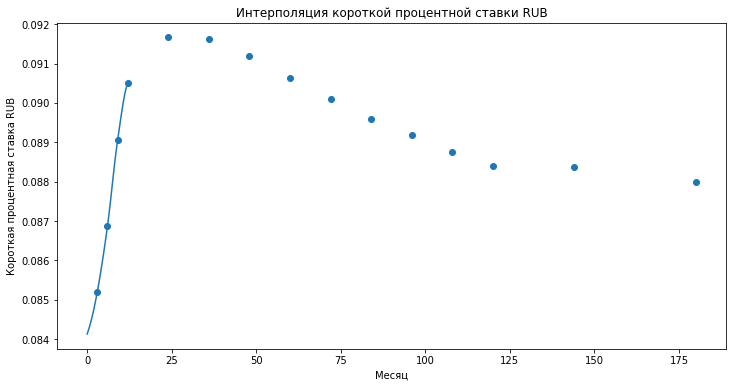

In [5]:
# здесь пока прогноз на ~ каждую неделю года
maturity_rub_new, irs_rub_new = interpolate_irs(maturity_rub, irs_rub, 0 * 12, 1 * 12, 1/4, 'RUB')

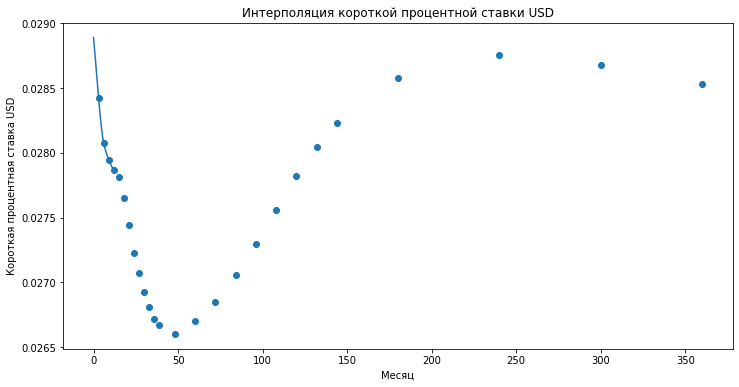

In [6]:
maturity_usd_new, irs_usd_new = interpolate_irs(maturity_usd, irs_usd, 0 * 12, 1 * 12, 1/4, 'USD')

Определим коэффициент $\theta$ с помощью разностной схемы и имеющихся процентных ставок

$\cfrac{r_j - r_{j - 1}}{\delta t} + \alpha r_{j-1} = \theta_{j-1}$

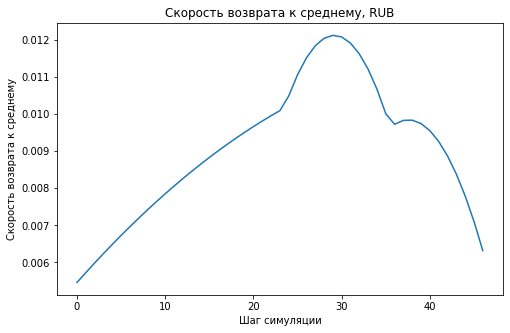

In [7]:
dt = 1 / (1 * 12 * 4)
T = np.arange(0, 1 * 12, 1/4)
alpha_rub = 0.03
sigma_rub = 0.03
theta_rub = (irs_rub_new[1:] - irs_rub_new[:-1]) / dt + alpha_rub * irs_rub_new[:-1]
plt.figure(figsize=(8, 5))
plt.plot(theta_rub)
plt.title('Скорость возврата к среднему, RUB')
plt.xlabel('Шаг симуляции')
plt.ylabel('Скорость возврата к среднему')
plt.show()

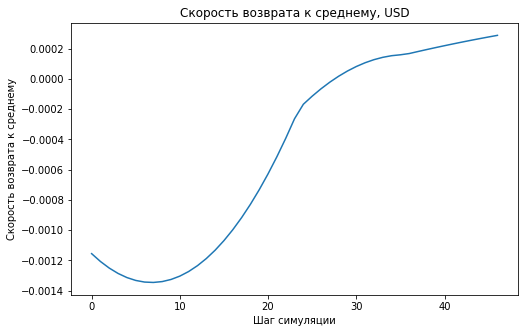

In [8]:
alpha_usd = 0.02
sigma_usd = 0.0093
theta_usd = (irs_usd_new[1:] - irs_usd_new[:-1]) / dt + alpha_usd * irs_usd_new[:-1]
plt.figure(figsize=(8, 5))
plt.plot(theta_usd)
plt.title('Скорость возврата к среднему, USD')
plt.xlabel('Шаг симуляции')
plt.ylabel('Скорость возврата к среднему')
plt.show()

Определим матрицу корреляций (это матрица 3х3):

1. Читаем данные LIBOR, Моспрайм и обменный курс USD/RUB. Для индикатвной ставки используем 3-х месячный показатель, как наиболее изменяющийся в зависимости от ожиданий, но не сильно подверженный резким колебаниям
2. Объединяем данные по времени, оставляем наблюдения за 2018 год (за год до начала симуляции)
3. Линейно заполняем пропуски. Начало и конец года удаляем
4. Считаем матрицу корреляции на основе прирощений полученных показателей
5. Применяем разложение Холецкого

In [9]:
epoch = pd.Timestamp('2018-01-01')

def interpolate_nan(df, col, date_col):
    df = df.copy()
    x = df[~df[col].isna()]
    f = interpolate.interp1d((x[date_col] - epoch).dt.days, x[col], bounds_error=False)
    x_nan = df[df[col].isna()]
    df.loc[df[col].isna(), col] = f((x_nan[date_col] - epoch).dt.days)
    return df

mosprime = pd.read_csv('./Моспрайм.csv', encoding='ANSI', sep=';')
mosprime.rename(columns={'Дата ставки': 'date', '3M': 'mosprime'}, inplace=True)
mosprime = mosprime[['date', 'mosprime']].copy()
mosprime['mosprime'] = mosprime['mosprime'].map(lambda x: x.replace(',', '.')).astype(np.float64)
mosprime['date'] = pd.to_datetime(mosprime['date'], format='%d-%m-%Y')

libor = pd.read_csv('./LIBOR.csv')
libor.columns = libor.columns.str.lower()
libor['date'] = pd.to_datetime(libor['date'])
libor.rename(columns={'usd3mtd156n': 'libor'}, inplace=True)
libor = libor[libor['libor'] != '.']
libor['libor'] = libor['libor'].astype(np.float64)
libor = libor.reset_index(drop=True)

fx = pd.read_csv('./FX.csv')
fx.columns = fx.columns.str.lower()
fx['date'] = pd.to_datetime(fx['date'])
fx.rename(columns={'close': 'fx'}, inplace=True)
fx = fx[['date', 'fx']].copy()

df_fin = pd.merge(mosprime, libor, on='date', how='outer')
df_fin = pd.merge(df_fin, fx, on='date', how='left')
df_fin = df_fin[(df_fin['date'] >= epoch) & (df_fin['date'] < pd.Timestamp('2019-01-01'))].copy()
df_fin = df_fin.sort_values('date').reset_index(drop=True)

df_fin = interpolate_nan(df_fin, 'mosprime', 'date')
df_fin = interpolate_nan(df_fin, 'libor', 'date')
df_fin = interpolate_nan(df_fin, 'fx', 'date')
df_fin = df_fin.dropna(axis=0) # Последний день

corr_matrix = np.linalg.cholesky(df_fin[['mosprime', 'libor', 'fx']].diff().dropna(axis=0).corr())
corr_matrix

array([[ 1.        ,  0.        ,  0.        ],
       [-0.05974034,  0.99821395,  0.        ],
       [-0.05174531, -0.10952429,  0.99263631]])

### Симуляция риск факторов

Зная коэффициент $\theta$, проведем симуляции коротких процентных ставок с помощью разностной схемы

$r_j = r_{j - 1} + (\theta_{j - 1} + \alpha r_{j - 1}) \delta t + \sigma dW_j$

Далее, используя полученные процентные ставки, вычислим обменный курс по формуле:

$fx_j = fx_{j - 1} + fx_{j - 1} ((r_{f_{j-1}} - r_{d_{j-1}} + \lambda) \delta t + \sigma dW_j$)

In [10]:
eps = 0.01 # порог для относительного изменения 95 квантили
T = len(theta_rub)
N = 100 # начальное количество симуляций
irs_rub_sim_all = []
irs_usd_sim_all = []
fx_sim_all = []
sigma_fx = 0.11
lam = 0.015
sim_diff_old = [0, 0, 0]
sim_diff_new = [1, 1, 1]
rnd = np.random.RandomState(42)

# критерий останова по симуляциям
while any([abs(sim_diff_old[0] / sim_diff_new[0] - 1) > eps,
           abs(sim_diff_old[1] / sim_diff_new[1] - 1) > eps,
           abs(sim_diff_old[2] / sim_diff_new[2] - 1) > eps]):
    for n in tqdm(range(N), total=N):
        irs_rub_sim = [irs_rub[0]]
        irs_usd_sim = [irs_usd[0]]
        fx_sim = [69.17] # обменный курс на 01.01.2019
        rnd_vec = corr_matrix @ rnd.normal(loc=0, scale=dt, size=(3, T - 1))
        for t in range(T-1):
            irs_rub_sim.append(irs_rub_sim[t] + (theta_rub[t] + alpha_rub * irs_rub_sim[t]) * dt + sigma_rub * rnd_vec[0, t])
            irs_usd_sim.append(irs_usd_sim[t] + (theta_usd[t] + alpha_usd * irs_usd_sim[t]) * dt + sigma_usd * rnd_vec[1, t])
            fx_sim.append(fx_sim[t] + fx_sim[t] * ((irs_usd_sim[t] - irs_rub_sim[t] + lam) * dt + sigma_fx * rnd_vec[2, t]))
        irs_rub_sim_all.append(irs_rub_sim)
        irs_usd_sim_all.append(irs_usd_sim)
        fx_sim_all.append(fx_sim)
    sim_diff_old = sim_diff_new
    sim_diff_new = [max(np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0)),
                    max(np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0)),
                    max(np.quantile(np.diff(fx_sim_all), q=0.95, axis=0))
                   ]

100%|██████████| 100/100 [00:00<00:00, 2702.39it/s]


In [11]:
irs_rub_sim_all = np.array(irs_rub_sim_all) * 100
irs_usd_sim_all = np.array(irs_usd_sim_all) * 100

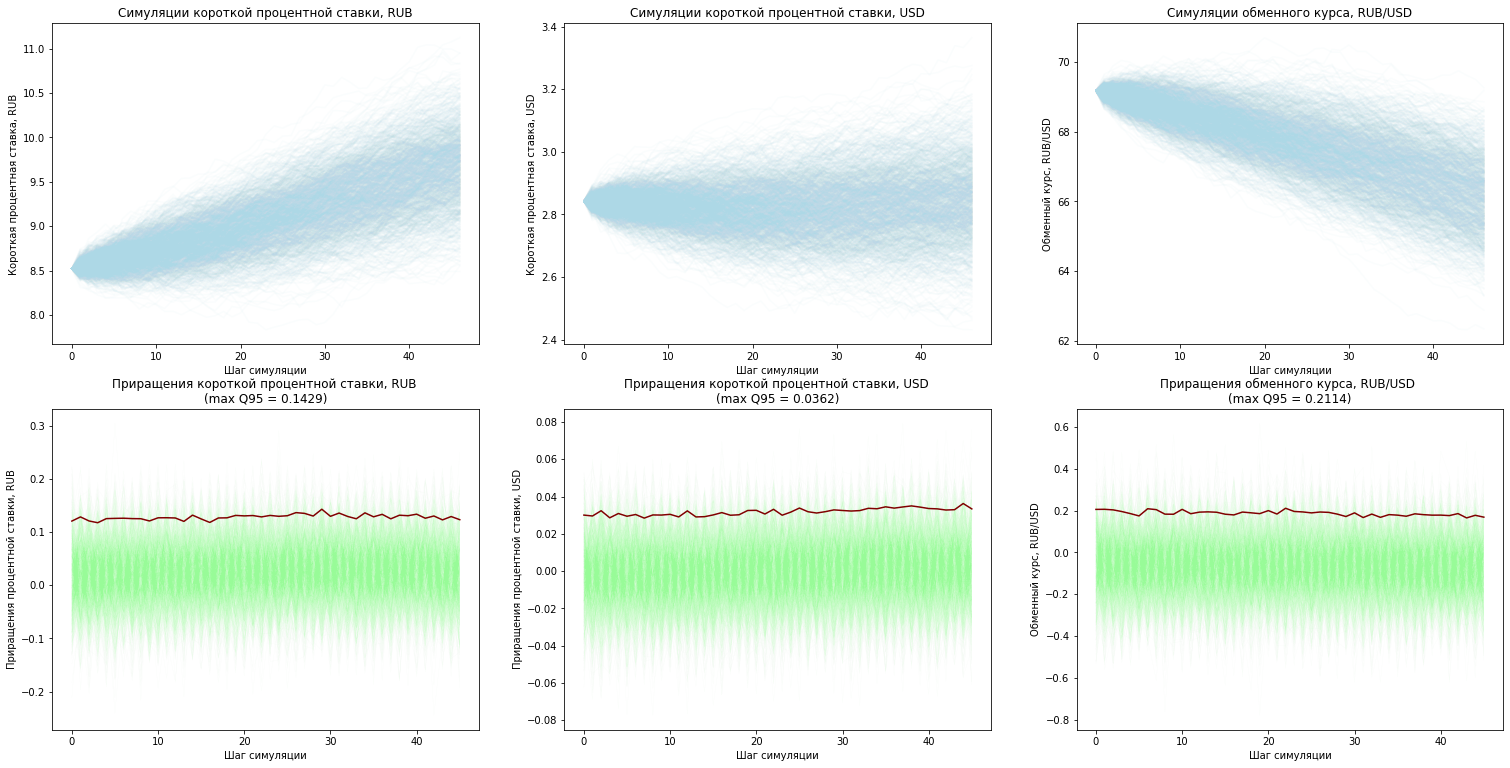

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(26, 13), )

axs[0, 0].plot(range(T), np.array(irs_rub_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 0].set_title('Симуляции короткой процентной ставки, RUB')
axs[0, 0].set_ylabel('Короткая процентная ставка, RUB')
axs[0, 0].set_xlabel('Шаг симуляции')

axs[1, 0].plot(range(T-1), np.diff(irs_rub_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 0].plot(range(T-1), np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 0].set_title(f'Приращения короткой процентной ставки, RUB \n(max Q95 = {round(max(np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 0].set_ylabel('Приращения процентной ставки, RUB')
axs[1, 0].set_xlabel('Шаг симуляции')

axs[0, 1].plot(range(T), np.array(irs_usd_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 1].set_title('Симуляции короткой процентной ставки, USD')
axs[0, 1].set_ylabel('Короткая процентная ставка, USD')
axs[0, 1].set_xlabel('Шаг симуляции')

axs[1, 1].plot(range(T-1), np.diff(irs_usd_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 1].plot(range(T-1), np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 1].set_title(f'Приращения короткой процентной ставки, USD \n(max Q95 = {round(max(np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 1].set_ylabel('Приращения процентной ставки, USD')
axs[1, 1].set_xlabel('Шаг симуляции')

axs[0, 2].plot(range(T), np.array(fx_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 2].set_title('Симуляции обменного курса, RUB/USD')
axs[0, 2].set_ylabel('Обменный курс, RUB/USD')
axs[0, 2].set_xlabel('Шаг симуляции')

axs[1, 2].plot(range(T-1), np.diff(fx_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 2].plot(range(T-1), np.quantile(np.diff(fx_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 2].set_title(f'Приращения обменного курса, RUB/USD \n(max Q95 = {round(max(np.quantile(np.diff(fx_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 2].set_ylabel('Обменный курс, RUB/USD')
axs[1, 2].set_xlabel('Шаг симуляции')
plt.show()

По итогам проведенной симуляции можно сказать, что на момент 01.01.2019 на рынке прогнозировался спад обменного курса - полученная динамика подтверждается реальными данными.

### Симуляция валютного форварда


Используем ранее полученные обменный курс / процентные ставки

Вопросы:

1) почему винеровский процеес нужно генерить из std нормального распределения - иначе получается явный тренд

2) почему 95 квантиль берем из приращений

3) какой именно взять период для моделирования